In [5]:
import networkx as nx
from utils import extract_CD_graph, draw_graph

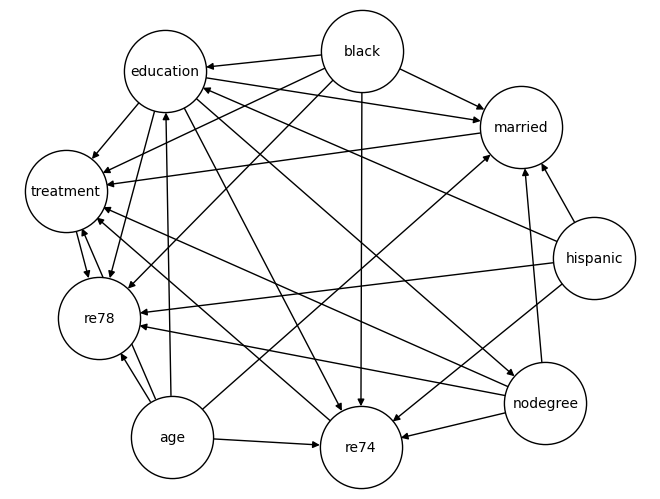

In [11]:
G = extract_CD_graph('graph_1603.json')
draw_graph(G)

In [12]:
nx.descendants(G, 'treatment') | {'treatment'}

{'re78', 'treatment'}

In [13]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

In [15]:
# creating a copy of our graph G that is undirected
H = G.to_undirected()

In [16]:
# the all_simple_paths function finds all possible undirected paths between 'treatment' and 're78' in graph H
all_possible_paths = list(nx.all_simple_paths(H, 'treatment', 're78'))
for path in all_possible_paths:
    print(path)

['treatment', 'black', 'married', 'hispanic', 'education', 'age', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 'age', 're74', 'nodegree', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 'nodegree', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 'nodegree', 're74', 'age', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 're74', 'age', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 're74', 'nodegree', 're78']
['treatment', 'black', 'married', 'hispanic', 're78']
['treatment', 'black', 'married', 'hispanic', 're74', 'age', 'education', 'nodegree', 're78']
['treatment', 'black', 'married', 'hispanic', 're74', 'age', 'education', 're78']
['treatment', 'black', 'married', 'hispanic', 're74', 'age', 're78']
['treatment', 'black', 'married', 'hispanic', 're74', 'education', 'age', 're78']
['treatment', 'black', 'married', 'hispani

In [17]:
# we can create a Backdoor object with G, 'treatment', and 're78'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
bd = backdoor.Backdoor(G, 'treatment', 're78')

In [18]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]
for path in backdoor_paths:
    print(path)

['treatment', 'black', 'married', 'hispanic', 'education', 'age', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 'age', 're74', 'nodegree', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 'nodegree', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 'nodegree', 're74', 'age', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 're74', 'age', 're78']
['treatment', 'black', 'married', 'hispanic', 'education', 're74', 'nodegree', 're78']
['treatment', 'black', 'married', 'hispanic', 're78']
['treatment', 'black', 'married', 'hispanic', 're74', 'age', 'education', 'nodegree', 're78']
['treatment', 'black', 'married', 'hispanic', 're74', 'age', 'education', 're78']
['treatment', 'black', 'married', 'hispanic', 're74', 'age', 're78']
['treatment', 'black', 'married', 'hispanic', 're74', 'education', 'age', 're78']
['treatment', 'black', 'married', 'hispani

In [20]:
# we create a pandas dataframe to track the path and its colliders and non-colliders
import pandas as pd
import numpy as np
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

In [21]:
for path in backdoor_paths:
    colliders = np.array([])
    non_colliders = []
    path_len = len(path)
    
    # we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
    for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
        # if there is an arrow pointing into node1 from both sides on the path, it is a collider
        if G.has_edge(node0, node1) and G.has_edge(node2, node1):
            colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
    # we flatten the list of list
    colliders = colliders.flatten()
    
    # any node on the path (excluding the source and target) that is not a collider is a non-collider
    non_colliders = [x for x in path[1:-1] if x not in colliders]
    
    # finally, we add the information to our dataframe, with the path, colliders, and non-colliders
    adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 

In [22]:
adjustment_variables

,path,colliders,non_colliders
0,"[treatment, black, married, hispanic, educatio...","[treatment, re78, married, treatment, married,...","[black, hispanic, age]"
1,"[treatment, black, married, hispanic, educatio...","[treatment, re78, married, treatment, married,...","[black, hispanic, age]"
2,"[treatment, black, married, hispanic, educatio...","[treatment, re78, married]","[black, hispanic, education, nodegree]"
3,"[treatment, black, married, hispanic, educatio...","[treatment, re78, married, treatment, re78, re74]","[black, hispanic, education, nodegree, age]"
4,"[treatment, black, married, hispanic, educatio...","[treatment, re78, married]","[black, hispanic, education]"
...,...,...,...
911,"[treatment, re74, nodegree, married, education...","[treatment, re78, married]","[re74, nodegree, education, black]"
912,"[treatment, re74, nodegree, married, education...","[treatment, re78, married]","[re74, nodegree, education, hispanic]"
913,"[treatment, re74, nodegree, married, education...","[treatment, re78, married]","[re74, nodegree, education, age]"
914,"[treatment, re74, nodegree, married, education...","[treatment, re78, married]","[re74, nodegree, education]"


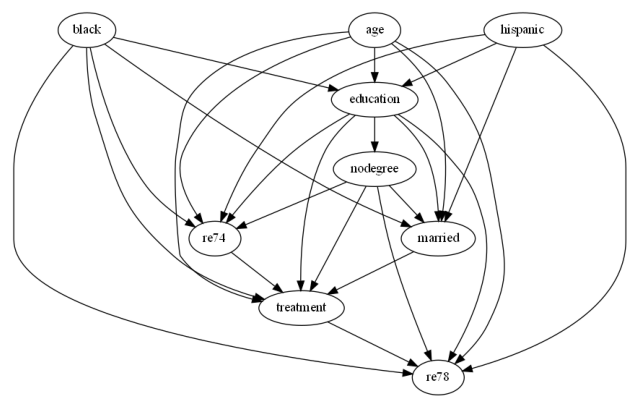

In [26]:
import dowhy
from dowhy import CausalModel

nx.write_gml(G, "graph.gml")
df = pd.DataFrame({'education':[1],'black':[1],'married':[1],'hispanic':[1],'nodegree':[1],'re74':[1],
                  'age': [1], 're78': [1], 'treatment': [1]})

def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('graph.gml')
# With GML string
model=CausalModel(
    data = df,
    treatment='treatment',
    outcome='re78',
    graph=gml_graph
)
model.view_model()

In [27]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                     
────────────(E[re78|age,nodegree,education,black,hispanic])
d[treatment]                                               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→re78 then P(re78|treatment,age,nodegree,education,black,hispanic,U) = P(re78|treatment,age,nodegree,education,black,hispanic)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [28]:
identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, model._graph.get_all_nodes())

[{'backdoor_set': ('married',
   'age',
   're74',
   'nodegree',
   'education',
   'black',
   'hispanic')},
 {'backdoor_set': ('age', 'nodegree', 'education', 'black', 'hispanic')}]